# Problem 1: Multiclass (30 %)

So far we have largely focused on binary classification, where the input is a document and the output is a yes or a no (or probability of yes). 

In fact, more complex tasks exist where the input is a document and the output can be multiple (more than two) classes. 

In this problem we'll investigate two so-called multiclass problems.

Multiclass: an observation is assigned inclusion in ONE of a N $N>2$ categories
 - E.g. is this sentence positive, negative, or neutral sentiment
 - E.g. is this email spam or not spam

Multiclass-multilabel: an observation can belong to more than one of $N>=2$ categories
 - E.g. is this document about `{sports, current events, Steph Curry}` ( a document can be about more than one)
 - E.g. is this blood sample A, B, O, $+$, $-$ (blood can be `A+` or `A-`)

We will study the metrics we can use to evaluate these classification problems.

In [1]:
import numpy as np
import pandas as pd
%pylab inline

import json

from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
np.random.seed(1234)

We will start with multiclass by studying the 20 newsgroups data.

## Part 0: get the data

 - Use the builtin function `from sklearn.datasets import fetch_20newsgroups`
 - NB: look at the docs and use the `remove` kwarg in order to get cleaned data

TODO
 - Fetch the data separately for the train and test data
 - How many classes are present? 
 - What is the most common class- please give the name and not the number.
 - What is the accuracy of the best constant guess in the train set?

In [3]:
from sklearn.datasets import fetch_20newsgroups

In [8]:
# Fetch the data separately for the train and test data
data_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
data_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
print(data_train.keys())
print(data_test.keys())
print(data_train['target_names'])
print(data_train['target'][:5])
print(data_train['filenames'][:5])
print(data_train['data'][0])

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
[ 7  4  4  1 14]
['/Users/bluebird/scikit_learn_data/20news_home/20news-bydate-train/rec.autos/102994'
 '/Users/bluebird/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.mac.hardware/51861'
 '/Users/bluebird/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.mac.hardware/51879'
 '/Users/bluebird/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38242'
 '/Users/bluebird/scikit_learn_data/20news_home/20news-bydate-train/sci.space/60880'

In [9]:
# How many classes are present?
val_counts = np.bincount(data_train.target)
print('found {} classes'.format(val_counts.shape[0]))

# What is the most common class- please give the name and not the number.
most_common_class_index = np.argmax(val_counts)
most_common_class = data_train.target_names[most_common_class_index]
print('most common class: {}'.format(most_common_class))

# What is the accuracy of the best constant guess in the train set?
dummy_acc = accuracy_score(data_train.target, [most_common_class_index] * len(data_train.target))
print('constant guess acc: {:.3f}'.format(dummy_acc))

found 20 classes
most common class: rec.sport.hockey
constant guess acc: 0.053


## Part 1: fit a model

As we saw with mnist, logistic regression is capable of fitting multi-class data.
 - Encode the text with as a bag of words and fit logistic regression to the data
 - Calcuate the out of sample accuracy score

TODO
1. Make a count vectorizer with max_features=20000
2. Fit it
3. Transform the train and test data into number

In [15]:
vec = CountVectorizer(max_features=20000)
vec.fit(data_train.data)

# your code here
xtr = vec.transform(data_train.data) # train data
xte = vec.transform(data_test.data) # test data
print(xtr.shape, xte.shape)

(11314, 20000) (7532, 20000)


TODO
1. Fit logistic regression
2. Compute accuracy score

In [16]:
# Fit logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(xtr, data_train.target)

# Compute accuracy score
preds = lr.predict(xte)
acc = accuracy_score(data_test.target, preds)
print('Out of sample accuracy: {:.3f}'.format(acc))

Out of sample accuracy: 0.592


## Part 2: Evaluate metrics

As we have seen previously, while accuracy is useful, it does not always capture all the behavior we want in a metric.

Here we will extend the concept of f1 score to the multiclass setting. There are several ways to do this
 - Report a different f1 score for every class (no averaging)
 - Report the mean f1 score over all classes
 - Report a weighted f1 score weighted by class prevelance. 

For each of these three types of f1
 - Calculate the score(s) without the help of scikit learn
 - Compare it to the corresponding f1 score evaluated with scikit-learn (NB you'll need to read the docs for `f1_score`.) 
 - Write down the pros and cons for this method of calculating multiclass f1 score

### Option 1: different score for every class
F1 score calculated for each class separately.

In [23]:
f1s = []

for label_index, label_name in enumerate(data_train.target_names):
    # For each class, treat it as "positive" and the rest as "negative"
    y_true = (data_test.target == label_index).astype(int)  # True labels (1 for the current class, 0 for others)
    y_pred = (preds == label_index).astype(int)  # Predicted labels in a one-vs-rest manner

    # Manually calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = np.sum((y_true == 1) & (y_pred == 1))  # Correctly predicted positive
    FP = np.sum((y_true == 0) & (y_pred == 1))  # Incorrectly predicted positive
    FN = np.sum((y_true == 1) & (y_pred == 0))  # Missed positive (predicted negative)

    # Calculate precision and recall manually
    if TP + FP == 0:
        precision = 0.0  # Avoid division by zero
    else:
        precision = TP / (TP + FP)
    
    if TP + FN == 0:
        recall = 0.0  # Avoid division by zero
    else:
        recall = TP / (TP + FN)
    
    # Calculate F1 score
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    # Append the F1 score for this class
    f1s.append(f1)

# Print the F1 scores for each class
for label_name, fs in zip(data_train.target_names, f1s):
    print('fscore for {} \t = {:.3f}'.format(label_name, fs))

fscore for alt.atheism 	 = 0.422
fscore for comp.graphics 	 = 0.582
fscore for comp.os.ms-windows.misc 	 = 0.560
fscore for comp.sys.ibm.pc.hardware 	 = 0.550
fscore for comp.sys.mac.hardware 	 = 0.617
fscore for comp.windows.x 	 = 0.660
fscore for misc.forsale 	 = 0.732
fscore for rec.autos 	 = 0.605
fscore for rec.motorcycles 	 = 0.631
fscore for rec.sport.baseball 	 = 0.556
fscore for rec.sport.hockey 	 = 0.810
fscore for sci.crypt 	 = 0.644
fscore for sci.electronics 	 = 0.485
fscore for sci.med 	 = 0.652
fscore for sci.space 	 = 0.628
fscore for soc.religion.christian 	 = 0.660
fscore for talk.politics.guns 	 = 0.508
fscore for talk.politics.mideast 	 = 0.657
fscore for talk.politics.misc 	 = 0.390
fscore for talk.religion.misc 	 = 0.305


In [30]:
# Compare with the built-in F1 score from sklearn
sklearn_f1s = f1_score(data_test.target, preds, average=None)
print('sklearn f1 scores:', sklearn_f1s)

# Round the F1 scores to 3 decimal places with a zero-padded format
f1s_str = ['{:.3f}'.format(fs) for fs in f1s]
print(' '.join(f1s_str))

sklearn f1 scores: [0.421875   0.58243081 0.55989583 0.54993515 0.61682243 0.66016713
 0.73232323 0.60539216 0.63133098 0.55566312 0.81019108 0.64444444
 0.4853129  0.65240642 0.62755102 0.65984655 0.50837989 0.65749656
 0.3898917  0.30522088]
0.422 0.582 0.560 0.550 0.617 0.660 0.732 0.605 0.631 0.556 0.810 0.644 0.485 0.652 0.628 0.660 0.508 0.657 0.390 0.305


Using equality is not the best for comparing decimals, changing the comparison method from what was provided. Visually above we can see they match.

In [33]:
success = np.allclose(f1s, sklearn_f1s, rtol=1e-3)
if success:
    print('sklearn builtin matches results')
else:
    print('scores do not match')

sklearn builtin matches results


- Pro: This method provides detailed performance per class, which is useful for identifying classes where the model struggles.
- Con: It can be cumbersome to interpret when dealing with many classes, as it does not provide a single summary score.

### Option 2: Mean over all classes
F1 score for each class, and then calculate the unweighted average over all classes.

In [38]:
# Manually calculate the macro-averaged F1 score
f1_macro = np.mean(f1s)  # Mean of the F1 scores across all classes - individual class F1 scores are already calculated

# Calculate the macro-averaged F1 score using scikit-learn
f1_macro_sk = f1_score(data_test.target, preds, average='macro')

# Check if the manually computed macro F1 score matches the sklearn F1 score
# Changed this from the original code to use np.isclose instead of direct comparison
assert np.isclose(f1_macro, f1_macro_sk, rtol=1e-3), "Macro F1 scores do not match"

# Print both manually computed and sklearn F1 macro scores
print('macro f1 (manual): {:.3f} \t sklearn macro f1: {:.3f}'.format(
    f1_macro, 
    f1_macro_sk
))

macro f1 (manual): 0.583 	 sklearn macro f1: 0.583


- Pro: Treats all classes equally, regardless of their frequency in the dataset.
- Con: May give misleading results when class distribution is imbalanced because rare classes have the same impact on the score as common ones.

### Option 3: Weighted mean
Classes which are more prevalent have their F1 scores count more in the resulting average.

Now weighted by class prevalence

TODO:
- Calculate the frequency of each class
- Take a weighted average of the f1s, weighted by these weights
- Compare to sklearn

In [39]:
# Calculate the weights for each class based on the number of true instances in the test set
wts = np.bincount(data_test.target) / len(data_test.target)  # Class frequencies as weights

# Manually calculate the weighted-averaged F1 score
weighted_f1 = np.sum(np.array(f1s) * wts)  # Sum of F1 scores weighted by class frequency

# Calculate the weighted-averaged F1 score using scikit-learn
weighted_f1_sk = f1_score(data_test.target, preds, average='weighted')  # Sklearn method for weighted F1 score

# Print both manually computed and sklearn weighted F1 scores
print('weighted f1 (manual): {:.3f} \t sklearn weighted f1: {:.3f}'.format(weighted_f1, weighted_f1_sk))

# Optional: Add a check to ensure the manually computed score matches sklearn's score
assert np.isclose(weighted_f1, weighted_f1_sk, rtol=1e-3), "Weighted F1 scores do not match"

weighted f1 (manual): 0.592 	 sklearn weighted f1: 0.592


- Pro: Better suited for imbalanced datasets, as it reflects the actual performance for the majority of the samples.
- Con: May overemphasize the performance on the majority classes and downplay the minority classes.

## Part 3: Confusion Matrix

The confusion matrix is a handy way to understand errors in classification problems. It is a 2-D grid of what values were predicted and what the actual values were. 

See [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) in the sklearn docs. 

Create a confusion matrix for the 20-newsgroups dataset and comment on the most common failure modes.

In [41]:
from sklearn.metrics import confusion_matrix
# your code here
# NB: it's handy to call `pd.DataFrame` on the confusion matrix to print it out nicely

# Calculate the confusion matrix
cm = confusion_matrix(data_test.target, preds)

# Convert confusion matrix to a dataframe
cm_df = pd.DataFrame(cm, index=data_train.target_names, columns=data_train.target_names)
cm_df

,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
alt.atheism,135,3,4,0,2,4,2,6,10,15,1,3,8,11,11,30,9,12,8,45
comp.graphics,3,242,17,9,10,27,10,4,5,14,2,4,17,4,10,1,1,3,2,4
comp.os.ms-windows.misc,4,31,215,41,17,15,3,7,4,19,1,7,3,6,8,0,2,4,4,3
comp.sys.ibm.pc.hardware,1,19,43,212,34,6,15,5,3,8,2,4,33,3,3,0,0,0,1,0
comp.sys.mac.hardware,0,9,13,35,231,1,15,11,8,17,6,4,22,2,7,1,2,0,1,0
comp.windows.x,0,54,40,13,4,237,7,2,2,12,0,4,4,1,7,3,1,4,0,0
misc.forsale,0,2,5,18,14,2,290,8,15,14,1,1,9,2,3,0,1,2,2,1
rec.autos,8,4,3,4,2,1,12,247,22,32,2,2,21,4,6,3,5,3,10,5
rec.motorcycles,7,4,0,3,4,1,4,32,268,22,2,3,16,5,8,0,3,5,8,3
rec.sport.baseball,8,3,0,0,3,0,5,8,13,287,29,0,4,4,9,6,2,6,7,3


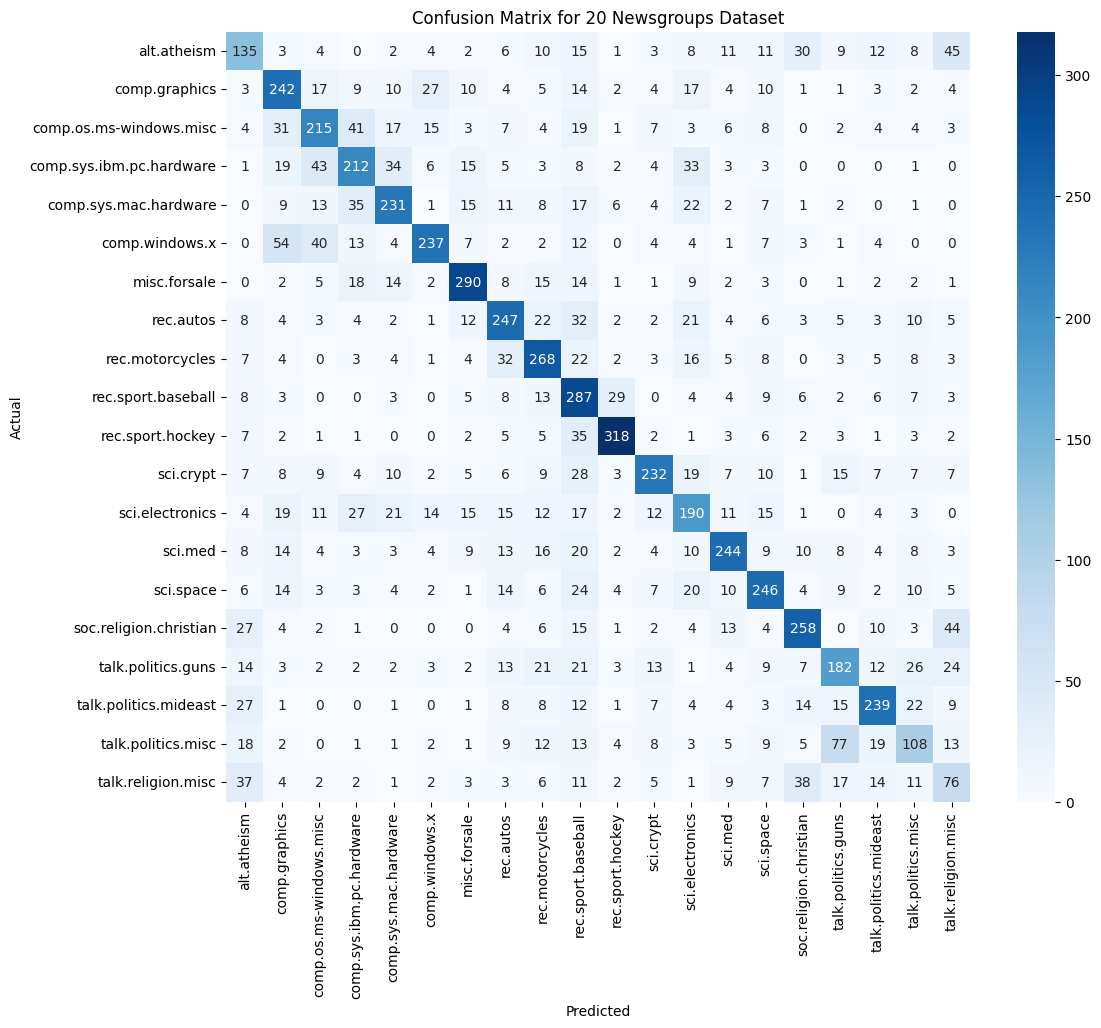

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_train.target_names, yticklabels=data_train.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for 20 Newsgroups Dataset')
plt.show()

Comments on the most common failure modes.

- Similar Topic Misclassification
    - Classes that represent similar topics (e.g., comp.graphics and comp.os.ms-windows.misc or talk.politics.misc and talk.politics.guns) are likely to have high misclassification rates. This happens because the vocabulary and context are often shared between similar topics, making it harder for the model to differentiate between them.
- Confusion Between Subtopics
    - In subcategories within larger domains (e.g., rec.sport.baseball and rec.sport.hockey), the model might confuse these classes due to the overlap in general sports-related terms.
- Overlapping Jargon
    - Groups related to computer topics (comp.*) might share technical jargon, which leads to higher confusion among those categories.
- General vs. Specific Topics
    - Classes that cover general topics (e.g., soc.religion.christian vs. talk.religion.misc) may result in misclassifications because the model has trouble distinguishing between discussions of religion in general versus specific religious discussions.

# Problem 2: Multiclass Multilabel Problems (20 %)

- In this problem we'll examine academic articles from the [arXiv](www.arxiv.org).
- Authors who submit articles can attach one or more categories to the articles.

## Part 0: Load the data

TODO
 - Load the data.
 - Compute all of the unique categories in the train data.
 - What are the 10 most common categories which occur together.

In [ ]:
with open('../../data/arxiv-qfin-train.json') as fi:
    data_train = json.load(fi)

with open('../../data/arxiv-qfin-test.json') as fi:
    data_test = json.load(fi)

    
print(len(data_train), len(data_test))

In [5]:
# compute the unique categories here


In [6]:
# compute the co-occuring categories here
# Hint:
#  - loop through all the train articles
#  - loop through all the pairs of categories
#  - keep track of the counts of every pair


## Part 1: Encode the data

We will encode the title of each article using a bag of words (`CountVectorizer`). Try limiting the features to about 20k. 

Encoding targets is as bit trickier for multilabel problems. In this case we want our target to be a matrix of $N_{samples} x N_{categories}$ but each row does not have to sum to 1.
 - NB: scikit learn as a `MultiLabelBinarizer` to help here. 

TODO
 - Fit a `CountVectorizer` on the titles to create `x_train` and `x_test`
 - Create `y_train` and `y_test` to be matrices of $N_{samples} x N_{categories}$ with all 0s and 1s

In [19]:
vec = CountVectorizer(...
vec.fit(...
x_train = ...
x_test = ...

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
# your code here

y_train = ...
y_test = ...
print(y_train.shape, y_test.shape)
print(list(mlb.classes_))

## Part 2: Model the data

- While scikit-learn can't handle multilabel data in logistic regression, keras can. 
- Create and fit a multilabel logistic regression model and fit it. 
- NB: think hard about the activation function and loss function that are appropriate in this case!

In [29]:
from keras.models import Model, Input
from keras.layers import Dense, Softmax, Dropout
import keras.backend as K

K.clear_session()
doc_input = Input( ...
# your code here
# dont forget to compile your model

In [ ]:
model.fit(
    ...
)

In [ ]:
pd.DataFrame(model.history.history)[['val_loss', 'val_accuracy']].plot(
    figsize=(12,7), secondary_y='val_loss'
)

## Part 3: f1 score

- While modeling is more difficult in the multilabel case, the metrics are, oddly, simpler. Here, we can only compute metrics class by class.
- For each class, print the accuracy and f1 score for the class. Comment on the results. 

In [ ]:
preds = model.predict(...
# loop through all the classes
# compute and print the accuracy and f1 for that class
for i, class_ in enumerate(mlb.classes_):
    acc = accuracy_score(y_test[:, i], preds[:, i])
    f1 = f1_score(y_test[:, i], preds[:, i])
    print('class{} \t\tacc: {:.3f} \tf1: {:.3f}'.format(class_, acc, f1))

# Problem 3: New Metrics (30%)

In this problem we'll explore new metrics associated with true positives and false positives.

## Part 1: Load the IMDB data and fit a model

 - Load the imdb data
 - Featurize the text using TFIDF
 - Fit logistic regression
 - Calculate the in-sample and out of sample accuracy and f1 score

In [16]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline


def load_imdb_data_text(imdb_data_dir, random_seed=1234):
    train_dir = os.path.join(imdb_data_dir, 'train')
    test_dir = os.path.join(imdb_data_dir, 'test')

    np.random.seed(random_seed)
    texts = []
    targets = []
    for label in ('pos', 'neg'):
        data_dir = os.path.join(train_dir, label)
        files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = (label == 'pos')
            texts.append(text)
            targets.append(target)

    train_docs = texts
    y_train = np.array(targets)


    texts = []
    targets = []
    for label in ('pos', 'neg'):
        data_dir = os.path.join(test_dir, label)
        files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = (label == 'pos')
            texts.append(text)
            targets.append(target)

    test_docs = texts
    y_test = np.array(targets)

    inds = np.arange(y_train.shape[0])
    np.random.shuffle(inds)

    train_docs = [train_docs[i] for i in inds]
    y_train = y_train[inds]
    
    return (train_docs, y_train), (test_docs, y_test)

(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text('../../data/aclImdb/')
print('found {} train docs and {} test docs'.format(len(train_docs), len(test_docs)))

Populating the interactive namespace from numpy and matplotlib
found 25000 train docs and 25000 test docs


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
vec = TfidfVectorizer...
# more code here


# more code here
preds_train = ...
preds_test = ...

print('#'*20 + ' in sample ' + '#'*20 )
print('\t\taccuracy: {:.3f}'.format(accuracy_score(y_train, preds_train)))
print('\t\tf1: {:.3f}'.format(f1_score(y_train, preds_train)))
print('\n\n')
print('#'*20 + ' out of sample ' + '#'*20 )
print('\t\taccuracy: {:.3f}'.format(accuracy_score(y_test, preds_test)))
print('\t\tf1: {:.3f}'.format(f1_score(y_test, preds_test)))

## Part 2: Tradeoff between true positives and false positives

Typically we take a threshold of 0.5 probability to consider something a positive example.
However, as we change this threshold we can change the number of true positives we get.
 - Example: at a theshold of 0.0001 we will get nearly all of the true positives
 - Example: at a threshold of 0.999 we will get almost none of the true positives

Notice: as we change our threshold and increase the number of true positives we will also increase the number of false positives we pick up.

In this part you will create a graph of the false positive rate on the x-axis and the true positive rate on the y-axis. This is often called the `receiver operator characteristic`. Make this curve for the out of sample data below.

Note: while you can use the builtin scikit-learn functionality for this, you will __not receive credit__ if you do. 

In [17]:
from tqdm import tqdm

In [ ]:
# your code here
# hint: 
#  - loop through the thresholds
#  - calulcate the true positives and false positives

# hint: what values for thresholds should you loop through?

In [ ]:
pd.Series(true_pos_rates, index=false_pos_rates).plot(figsize=(12,8), fontsize=16)
plt.xlabel('False Pos Rate', fontsize=16)
plt.ylabel('True Pos Rate', fontsize=16)
plt.title('Receiver Operator Characteristic', fontsize=20)

## Part 3: Baseline

 - What does the receiver operator curve look like for a random guessing classifier? 
 - Make the same plot as above but add the random guessing curve
 - Add comments about WHY the random guessing curve looks this way

In [ ]:
ax = pd.Series(true_pos_rates, index=false_pos_rates, name='logistic regression').plot(
    figsize=(12,8), fontsize=16
)
baseline_series = ... # your code here for the ROC for random guessing
baseline_series.to_frame('random guess').plot(ax=ax, fontsize=16)
plt.xlabel('False Pos Rate', fontsize=16)
plt.ylabel('True Pos Rate', fontsize=16)
plt.title('Receiver Operator Characteristic', fontsize=20)
plt.legend(fontsize=16)

In [38]:
# add comments here

## Part 4: Boiling it down to a single number

 - While the ROC is a useful curve and contains a lot of information, it is useful to distill in down to a single number. Typically, the area under the curve is used. Calculate the area under the curve and add it as the title to your previous plot. 
 - Hint: think about approximations for integrals for finding area under a curve

In [ ]:
area_under = # your code here


# repeat the plotting code here

plt.title('Area under the curve = {:.3f}'.format(area_under, fontsize=20))
plt.legend(fontsize=16)

## Part 5: Check you work and comment on the results

 - "There's gotta be a better way!"
 - In fact, `scikit-learn` will take care of a lot of the headache here. 
 - `from sklearn.metrics import plot_roc_curve`
 - read the docs and use this function

In [ ]:
from sklearn.metrics import plot_roc_curve, auc
# your code here

### A few comments:
 - The area under the ROC has a nice interpretation. It can be thought of as the probability that a randomly chosen positive example has a higher probability than a randomly chosen negative example.
 - This metric is also nice since it is independent of a threshold. 

# Problem 4: Examining Coefficients (20%)

In class we skipped an important step: we never made sure our models made sense. 
Logistic regression provides coefficients, which allow us to determine if a model
if learning anything reasonable. 

In this problem, you'll load the imdb data, fit logistic regression and exmamine the coefficients. 
Print out the largest and smallest (largest negative) coefficients and comment on the results.

In [8]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

# copy code from above to load the data


In [2]:
(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text('../../data/aclImdb/')
print('found {} train docs and {} test docs'.format(len(train_docs), len(test_docs)))

found 25000 train docs and 25000 test docs


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

vec = TfidfVectorizer(...
# more code here
                      
lr = LogisticRegression(...


In [ ]:
# Hint: you can call `vec.get_feature_names` to get the words in order
# that correspond to the columns of the TFIDF matrix 
# This is useful to pass to the index of a pd.Series

In [ ]:
coefs = pd.Series(...)

# NB: to get the largest items in a series by abs try
#    coefs.loc[coefs.abs().nlargest(20).index]

In [9]:
# comments here